In [246]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_circles
from matplotlib import pyplot as plt
# from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
# from sklearn.mixture import GaussianMixture
import cvxpy as cp
# from numpy import linalg as LA
from matplotlib.pyplot import cm
import time
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Classes with the following clustering algorithms: K-Means, spectral clustering, and Gaussian mixture

In [199]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, data):
        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [200]:
class SpectralClustering:
    #define params
    def __init__(self, k=2, method='random'):
        self.k = 2 #numb of clusters
        self.iterationCounter = 0 #clustering iteration counter
        self.initCentroidMethod = method #options: random, kmeans++, badInit, zeroInit

    def initCentroid(self, dataIn, method, k):
        if (method=="random"):
            result = dataIn[np.random.choice(dataIn.shape[0], k, replace=False)]
        if (method=="kmeans++"):
            euclideanMatrixAllCentroid = np.ndarray(shape=(dataIn.shape[0], 0))
            allCentroid = np.ndarray(shape=(0,dataIn.shape[1]))
            first = dataIn[np.random.choice(dataIn.shape[0], 1, replace=False)]
            allCentroid = np.concatenate((allCentroid, first), axis=0)
            repeatedCent = np.repeat(first, dataIn.shape[0], axis=0)
            deltaMatrix = abs(np.subtract(dataIn, repeatedCent))
            euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
            indexNextCent = (np.argmax(np.matrix(euclideanMatrix)))
            if(k>1):
                for a in range(1,k):
                    nextCent = np.matrix(dataIn[np.item(indexNextCent),:])
                    allCentroid = np.concatenate((allCentroid, nextCent), axis=0)
                    for i in range(0,allCentroid.shape[0]):
                        repeatedCent = np.repeat(allCentroid[i,:], dataIn.shape[0], axis=0)
                        deltaMatrix = abs(np.subtract(dataIn, repeatedCent))
                        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
                        euclideanMatrixAllCentroid = \
                            np.concatenate((euclideanMatrixAllCentroid, euclideanMatrix), axis=1)
                    euclideanFinal = np.min(np.matrix(euclideanMatrixAllCentroid), axis=1)
                    indexNextCent = np.argmax(np.matrix(euclideanFinal))
            result = allCentroid
        if (method=="badInit"):
            allCentroid = np.ndarray(shape=(0,dataIn.shape[1]))
            firstIndex = np.random.randint(0,dataIn.shape[0])
            first = np.matrix(dataIn[firstIndex,:])
            dataIn = np.delete(dataIn, firstIndex, 0)
            allCentroid = np.concatenate((allCentroid, first), axis=0)
            repeatedCent = np.repeat(first, dataIn.shape[0], axis=0)
            deltaMatrix = abs(np.subtract(dataIn, repeatedCent))
            euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
            indexNextCent = (np.argmin(np.matrix(euclideanMatrix)))
            if(k>1):
                for a in range(1,k):
                    nextCent = np.matrix(dataIn[np.item(indexNextCent),:])
                    dataIn = np.delete(dataIn, np.item(indexNextCent), 0)
                    euclideanMatrixAllCentroid = np.ndarray(shape=(dataIn.shape[0], 0))
                    allCentroid = np.concatenate((allCentroid, nextCent), axis=0)
                    for i in range(0,allCentroid.shape[0]):
                        repeatedCent = np.repeat(allCentroid[i,:], dataIn.shape[0], axis=0)
                        deltaMatrix = abs(np.subtract(dataIn, repeatedCent))
                        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
                        euclideanMatrixAllCentroid = \
                            np.concatenate((euclideanMatrixAllCentroid, euclideanMatrix), axis=1)
                    euclideanFinal = np.min(np.matrix(euclideanMatrixAllCentroid), axis=1)
                    indexNextCent = np.argmin(np.matrix(euclideanFinal))
            result = allCentroid
        if (method=="zeroInit"):
            result = np.matrix(np.full((k,dataIn.shape[1]),0))

        return result

    def plotClusterResult(self, listClusterMembers, centroid, iteration, converged):
        n = listClusterMembers.__len__()
        color = iter(cm.rainbow(np.linspace(0, 1, n)))
        plt.figure("result")
        plt.clf()
        plt.title("iteration-" + iteration)
        for i in range(n):
            col = next(color)
            memberCluster = np.asmatrix(listClusterMembers[i])
            plt.scatter(np.ravel(memberCluster[:, 0]), np.ravel(memberCluster[:, 1]), marker=".", s=100, color=col)
            plt.scatter((centroid[i, 0]), (centroid[i, 1]), marker="+", s=400, color=col, edgecolors="black")
        if(converged == 0):
            plt.ion()
            plt.show()
            plt.pause(0.1)
        if (converged == 1):
            plt.show(block=True)
    
    def kMeans(self, data, centroidInit):
        nCluster = centroidInit.shape[0]
        centroidInit = np.matrix(centroidInit)
        while(True):
            self.iterationCounter +=1
            euclideanMatrixAllCluster = np.ndarray(shape=(data.shape[0], 0))
            #assign data to cluster whose centroid is the closest one
            for i in range(0, nCluster):
                centroidRepeated = np.repeat(centroidInit[i,:], data.shape[0], axis=0)
                deltaMatrix = abs(np.subtract(data,centroidRepeated))
                euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
                euclideanMatrixAllCluster = \
                    np.concatenate((euclideanMatrixAllCluster, euclideanMatrix), axis=1)
            clusterMatrix = np.ravel(np.argmin(np.matrix(euclideanMatrixAllCluster), axis=1))
            listClusterMember = [[] for i in range(self.k)]
            for i in range(0, data.shape[0]):#assign data to cluster regarding cluster matrix
                listClusterMember[np.asscalar(clusterMatrix[i])].append(data[i,:])
            #calculate new centroid
            newCentroid = np.ndarray(shape=(0, centroidInit.shape[1]))
            for i in range(0,nCluster):
                memberCluster = np.asmatrix(listClusterMember[i])
                centroidCluster = memberCluster.mean(axis=0)
                newCentroid = np.concatenate((newCentroid, centroidCluster), axis=0)
            #break when converged
            if((centroidInit == newCentroid).all()):
                break
            # update new centroid
            centroidInit = newCentroid
            # self.plotClusterResult(listClusterMember, centroidInit, str(self.iterationCounter), 0)
            # time.sleep(1)
        return listClusterMember, centroidInit

    def fit(self, input, initCentroidMethod='random', k=2):
        centroidInit = self.initCentroid(input, initCentroidMethod, k)
        clusterResults, centroid = self.kMeans(input, centroidInit)
        self.plotClusterResult(clusterResults, centroid, str(self.iterationCounter) + " (converged)", 1)
        return { 'clusters': clusterResults, 'centroids': centroid }

In [201]:
class GaussianMixtureClustering:
    def __init__(self, n_components, max_iter = 100, comp_names=None):
        self.n_componets = n_components
        self.max_iter = max_iter
        if comp_names == None:
            self.comp_names = [index for index in range(self.n_componets)]
        else:
            self.comp_names = comp_names
        # pi list contains the fraction of the dataset for every cluster
        self.pi = [1/self.n_componets for comp in range(self.n_componets)]

    def multivariate_normal(self, X, mean_vector, covariance_matrix):
        return (2*np.pi)**(-len(X)/2)*np.linalg.det(covariance_matrix)**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector))/2)

    def fit(self, X):
        # Spliting the data in n_componets sub-sets
        new_X = np.array_split(X, self.n_componets)
        # Initial computation of the mean-vector and covarience matrix
        self.mean_vector = [np.mean(x, axis=0) for x in new_X]
        self.covariance_matrixes = [np.cov(x.T) for x in new_X]
        # Deleting the new_X matrix because we will not need it anymore
        del new_X
        for iteration in range(self.max_iter):
            ''' --------------------------   E - STEP   -------------------------- '''
            # Initiating the r matrix, evrey row contains the probabilities
            # for every cluster for this row
            self.r = np.zeros((len(X), self.n_componets))
            # Calculating the r matrix
            for n in range(len(X)):
                for k in range(self.n_componets):
                    self.r[n][k] = self.pi[k] * self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                    self.r[n][k] /= sum([self.pi[j]*self.multivariate_normal(X[n], self.mean_vector[j], self.covariance_matrixes[j]) for j in range(self.n_componets)])
            # Calculating the N
            N = np.sum(self.r, axis=0)
            ''' --------------------------   M - STEP   -------------------------- '''
            # Initializing the mean vector as a zero vector
            self.mean_vector = np.zeros((self.n_componets, len(X[0])))
            # Updating the mean vector
            for k in range(self.n_componets):
                for n in range(len(X)):
                    self.mean_vector[k] += self.r[n][k] * X[n]
            self.mean_vector = [1/N[k]*self.mean_vector[k] for k in range(self.n_componets)]
            # Initiating the list of the covariance matrixes
            self.covariance_matrixes = [np.zeros((len(X[0]), len(X[0]))) for k in range(self.n_componets)]
            # Updating the covariance matrices
            for k in range(self.n_componets):
                self.covariance_matrixes[k] = np.cov(X.T, aweights=(self.r[:, k]), ddof=0)
            self.covariance_matrixes = [1/N[k]*self.covariance_matrixes[k] for k in range(self.n_componets)]
            # Updating the pi list
            self.pi = [N[k]/len(X) for k in range(self.n_componets)]
    def predict(self, X):
        probas = []
        for n in range(len(X)):
            probas.append([self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                           for k in range(self.n_componets)])
        cluster = []
        for proba in probas:
            cluster.append(self.comp_names[proba.index(max(proba))])
        return cluster

# Define the dataset: toy example

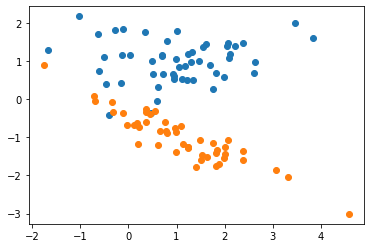

In [270]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=3)

for class_value in range(2):
    row_ix = np.where(y == class_value)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
plt.show()

# Clustering

## K-Means clustering

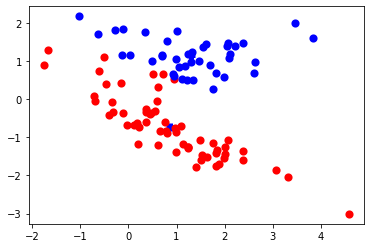

In [271]:
kmeans = K_Means()
kmeans.fit(X)

for centroid in kmeans.centroids:
    plt.scatter(kmeans.centroids[centroid][0], kmeans.centroids[centroid][1],
                marker="+", color="b", s=50, linewidths=5)

colors = ['r', 'b', 'g', 'k', 'y']
cluster_number = 0
for classification in kmeans.classifications:
    for featureset in kmeans.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="o", color=colors[cluster_number], s=10, linewidths=5)
    cluster_number += 1
        
plt.show()

In [272]:
pred = []
for el in X:
    if np.any(np.all(el == kmeans.classifications[0], axis=1)):
        pred.append(0)
    else:
        pred.append(1)

In [273]:
print(
    'ARI: {}\nAMI: {}'.format(
        adjusted_rand_score(y, pred), 
        adjusted_mutual_info_score(y, pred)
        )
    )

ARI: 0.5734430082256169
AMI: 0.5711709879016148


## Spectral clustering

c:\users\tasue\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:97: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
c:\users\tasue\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:73: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


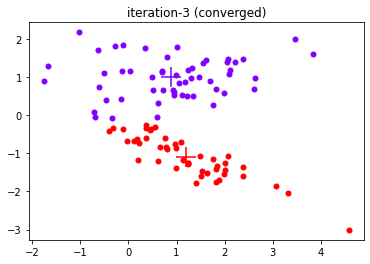

In [275]:
spectral = SpectralClustering()
res = spectral.fit(X)

## Gaussian mixture clustering

In [276]:
gmc = GaussianMixtureClustering(2)
gmc.fit(X)

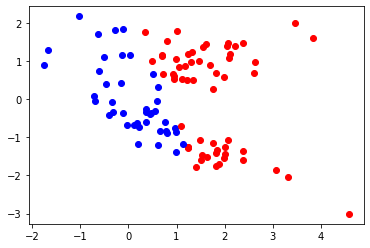

In [277]:
res = gmc.predict(X)
clusters = [[] for i in range(2)]

colors = ['r', 'b', 'b', 'y', 'k']

for i in range(len(res)):
    cluster_id = res[i]
    clusters[cluster_id].append(X[i])
    plt.scatter(X[i, 0], X[i, 1], c=colors[cluster_id])
plt.show()

In [278]:
pred = gmc.predict(X)
print(
    'ARI: {}\nAMI: {}'.format(
        adjusted_rand_score(y, pred), 
        adjusted_mutual_info_score(y, pred)
        )
    )

ARI: 0.03897237726506867
AMI: 0.02725269209426096


## Convex clustering

In [208]:
class ConvexClustering:
    def __init__(self, alpha=2):
        self.alpha = alpha
    
    @staticmethod
    def sum_substrcts(X, j):
        sum = 0
        for j1 in range(1, j):
            for i in range(0, j1):
                sum += cp.atoms.norm(X[i] - X[j1], p=2)
        return sum

    @staticmethod
    def subsc_row(a, b):
        return np.sum(a - b)
    
    def fit(self, A):
        m, n = A.shape
        X = cp.Variable((m, n))
        z_function = cp.atoms.norm(A - X, 'fro') ** 2 + self.alpha * self.sum_substrcts(X, m)
        problem = cp.Problem(cp.Minimize(z_function))
        problem.solve()
        res = X.value
        return res
    
    def predict(self, res, A, thresh=0.5):
        cluster_0 = []
        cluster_1 = []

        for i in range(len(res)):
            if abs(self.subsc_row(res[0], res[i])) <= thresh:
                cluster_0.append(A[i])
            else:
                cluster_1.append(A[i])
        return cluster_0, cluster_1

    @staticmethod
    def visualize_clusters(cluster_0, cluster_1):
        x_0 = [x[0] for x in cluster_0]
        y_0 = [x[1] for x in cluster_0]
        plt.plot(x_0, y_0, 'bo')

        x_1 = [x[0] for x in cluster_1]
        y_1 = [x[1] for x in cluster_1]
        plt.plot(x_1, y_1, 'ro')

        plt.plot(cluster_0[0][0], cluster_0[0][1], 'y+')
        plt.show()

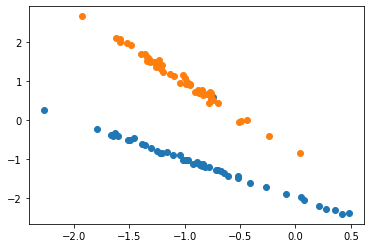

In [264]:
# good examples 1 3 12 16 17 22 25 26 40
# bad examples: 20 23 29
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=12)

for class_value in range(2):
    row_ix = np.where(y == class_value)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
plt.show()


# X, y = make_circles(n_samples=100, random_state=123)

# for class_value in range(2):
#     row_ix = np.where(y == class_value)
#     plt.scatter(X[row_ix, 0], X[row_ix, 1])
# plt.show()


In [253]:
convcl = ConvexClustering()
res = convcl.fit(X)

In [254]:
a = []
for i in range(len(res)):
    a.append(abs(convcl.subsc_row(res[0], res[i])))
a = np.array(a)
a.min(), a.max(), a.mean()

(0.0, 3.8419905776557974e-13, 1.7310978340741723e-13)

In [255]:
# 8.083414590953295e-13

In [256]:
thresholds = np.linspace(a.min(), a.max(), 200)
ari_opt = 0
ami_opt = 0
thresh_opt = 0
for t in thresholds:
#     print(t)
    pred = []
    cluster_0, cluster_1 = convcl.predict(res, X, thresh=t)
    for r in res:
        if abs(convcl.subsc_row(res[0], r)) <= t:
            pred.append(0)
        else:
            pred.append(1)
    ari = adjusted_rand_score(y, pred)
    ami = adjusted_mutual_info_score(y, pred)
    if ari >= ari_opt and ami >= ami_opt:
        ari_opt = ari
        ami_opt = ami
        thresh_opt = t
#     print('ARI: {}\nAMI: {}'.format(ari, ami))
#     convcl.visualize_clusters(cluster_0, cluster_1)

2.8959727972279884e-14
ARI: 0.0364963503649635
AMI: 0.13811404698874086


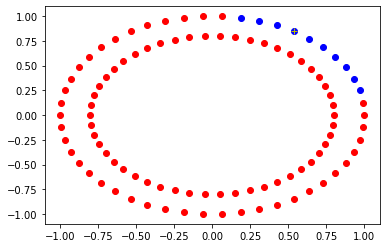

In [258]:
print(thresh_opt)
pred = []
cluster_0, cluster_1 = convcl.predict(res, X, thresh=thresh_opt)
for r in res:
    if abs(convcl.subsc_row(res[0], r)) <= thresh_opt:
        pred.append(0)
    else:
        pred.append(1)
ari = adjusted_rand_score(y, pred)
ami = adjusted_mutual_info_score(y, pred)
print('ARI: {}\nAMI: {}'.format(ari, ami))
convcl.visualize_clusters(cluster_0, cluster_1)

# Define the dataset: Moons

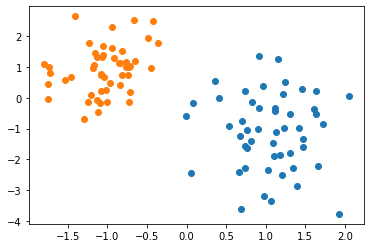

In [38]:
# 4 6
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=8)

for class_value in range(2):
    row_ix = np.where(y == class_value)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
plt.show()

In [22]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [23]:
all_X = np.append(train_X.reshape((train_X.shape[0], -1)), test_X.reshape((test_X.shape[0], -1)), axis=0)
all_y = np.append(train_y, test_y, axis=0)
all_X.shape, all_y.shape

((70000, 784), (70000,))

In [28]:
for y in np.unique(all_y):
    print(y, len(all_y[all_y == y]))

0 6903
1 7877
2 6990
3 7141
4 6824
5 6313
6 6876
7 7293
8 6825
9 6958


MNIST dataset is very huge, we will consider 20 pictures of each digit

In [43]:
X = []
y = []
for d in np.unique(all_y):
    print(d, len(all_y[all_y == d]))
    X.append(all_X[all_y == d][:2])
    y.append(all_y[all_y == d][:2])
X = np.array(X).reshape((-1, all_X.shape[1]))
y = np.array(y).reshape((-1, ))
X.shape, y.shape

0 6903
1 7877
2 6990
3 7141
4 6824
5 6313
6 6876
7 7293
8 6825
9 6958


((20, 784), (20,))

## Convex clustering

In [44]:
convcl = ConvexClustering(alpha=10)
res = convcl.fit(X)

c:\users\tasue\appdata\local\programs\python\python37\lib\site-packages\cvxpy\problems\problem.py:1295: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


In [50]:
res[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [52]:
a = []
for i in range(len(res[0])):
    a.append(abs(convcl.subsc_row(res[0][0], res[0][i])))
a = np.array(a)
a.min(), a.max(), a.mean()

(0.0, 250.16115756385992, 39.3524323211512)

39.3524323211512
len of cluster_0: 1
len of cluster_1: 19
ARI: 0.0
AMI: -1.014829413346934e-15


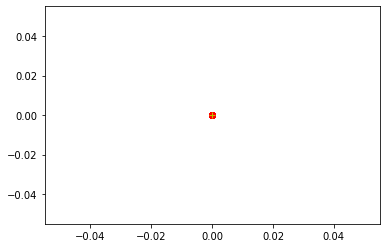

In [54]:
print(a.mean())
pred = []
cluster_0, cluster_1 = convcl.predict(res, X, thresh=a.mean())
for r in res:
    if abs(convcl.subsc_row(res[0], r)) <= a.mean():
        pred.append(0)
    else:
        pred.append(1)
ari = adjusted_rand_score(y, pred)
ami = adjusted_mutual_info_score(y, pred)
print('ARI: {}\nAMI: {}'.format(ari, ami))
convcl.visualize_clusters(cluster_0, cluster_1)